In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import matplotlib.pyplot as plt
import time
import numpy as np
import pandas as pd

In [2]:
def normalize(df):
    result = df.copy()
    print(len(result.transpose()))
    for feature_name in range(len(result.transpose())):
        max_value = df[1:1800, feature_name].max()
        min_value = df[1:1800, feature_name].min()
        a = 1 / (max_value-min_value)
        b = 1 - a * max_value
        result[1:1800,feature_name] = (df[1:1800, feature_name] * a + b)
    return result

In [64]:
class ecg2class(nn.Module):
    def __init__(self):
        super(ecg2class, self).__init__()
        self.conv1 = nn.Conv1d(1, 30, 5)
        self.conv2 = nn.Conv1d(30, 30, 5)
        self.conv3 = nn.Conv1d(30, 15, 5)
        self.conv4 = nn.Conv1d(15, 15, 5)
        self.conv5 = nn.Conv1d(15, 15, 5)
        self.fc1 = nn.Linear(217*15, 217*3)
        self.fc2 = nn.Linear(217*3, 217)
        self.fc3 = nn.Linear(217, 3)
        
        data0 = pd.read_csv('arrhythmia5_TrainData.csv', header=None, low_memory=False)
        y = data0.values.astype(float)
        self.z = normalize(y)
        
        valdata0 = pd.read_csv('arrhythmia5_ValData.csv', header=None, low_memory=False)
        valy = valdata0.values.astype(float)
        self.valz = normalize(valy)
    
    def train(self):
        mbatch = 242;
        mepoch = 25;
        output_nodes = 3;
        num_batch = 2;
        vnum_batch = 1;
        vmbatch = 58;
        convDrop = nn.Dropout(p=0.2)
        MLPDrop = nn.Dropout(p=0.5)
        tanh = nn.Tanh()
        softmax = nn.Softmax(1)
        
        trainsumerrora = []
        valsumerrora = []
        accuracya = []
        accuracya1 = []
        epocha = []
        starttime = time.time()
        optimizer = optim.SGD(self.parameters(), lr = 0.01, momentum = 0.9)
        criterion = nn.CrossEntropyLoss()
        out_loss = nn.MSELoss()
        
        for epoch in range(0, mepoch):
            epocha.append(epoch)  
            trainsumerror = 0
            valsumerror = 0
            x = np.random.permutation(self.z.transpose())
            data1 = torch.FloatTensor(x.transpose())
            input_date = data1[1:1799].unsqueeze(1).transpose(0,2)
            labels = data1[0]
            
            count1 = 0
            
            for z in range(num_batch):
                optimizer.zero_grad()
                start = int(mbatch / num_batch  * z);
                finish = int(mbatch / num_batch * (z+1)- 1);
                input_dat = input_date[start:finish, :, :]
                target_matrix = torch.zeros(output_nodes, int(mbatch / num_batch)-1).double()
                
                for batch in range(int(mbatch/num_batch)-1):
                    idx = start + batch
                    target_matrix[int(labels[idx]), batch] = 1
                    
                
                targetV = Variable(target_matrix.float())
                
                out = tanh(self.conv1(Variable(input_dat)))
                out = tanh(self.conv2(out))
                out = F.max_pool1d(out, 2)
                out = convDrop(out)
                out = tanh(self.conv3(out))
                out = tanh(self.conv4(out))
                out = F.max_pool1d(out, 2)
                out = convDrop(out)
                out = tanh(self.conv4(out))
                out = tanh(self.conv5(out))
                out = F.max_pool1d(out, 2)
                out = convDrop(out)
                out = out.view(-1, 217*15)
                out = tanh(self.fc1(out))
                out = MLPDrop(out)
                out = tanh(self.fc2(out))
                out = MLPDrop(out)
                out = tanh(self.fc3(out))
                out = MLPDrop(out)
                out = softmax(out)
                
                #loss = out_loss(out.float(), targetV.float())
                #print(torch.max(targetV.long(),0)[1])
                loss = criterion(out.float(), torch.max(targetV,0)[1])
                loss.backward()
                optimizer.step()
            
                trainsumerror = trainsumerror + loss[0].detach().numpy()[0]
                
                for batch in range(int(mbatch/num_batch)-1):
                    if torch.max(targetV,0)[1][batch] == torch.max(out,1)[1][batch]:
                        count1 = count1 + 1
                        
            accuracy1 = count1/mbatch
                
            count = 0
            valx = np.random.permutation(self.valz.transpose())
            valdata1 = torch.FloatTensor(valx.transpose())
            valinput_dat = valdata1[1:1799].unsqueeze(1).transpose(0,2)
            vallabels = valdata1[0]
            
            for z in range(vnum_batch):
                valtarget_matrix = torch.zeros(output_nodes, int(vmbatch / vnum_batch)).double()
                
                for batch in range(int(vmbatch/vnum_batch)):
                    valtarget_matrix[int(labels[batch]), batch] = 1
                    
                
                valtargetV = Variable(valtarget_matrix.float())
                
                out = tanh(self.conv1(Variable(valinput_dat)))
                out = tanh(self.conv2(out))
                out = F.max_pool1d(out, 2)
                out = convDrop(out)
                out = tanh(self.conv3(out))
                out = tanh(self.conv4(out))
                out = F.max_pool1d(out, 2)
                out = convDrop(out)
                out = tanh(self.conv4(out))
                out = tanh(self.conv5(out))
                out = F.max_pool1d(out, 2)
                out = convDrop(out)
                out = out.view(-1, 217*15)
                out = tanh(self.fc1(out))
                out = MLPDrop(out)
                out = tanh(self.fc2(out))
                out = MLPDrop(out)
                out = tanh(self.fc3(out))
                out = MLPDrop(out)
                out = softmax(out)
                
                #out_lossv = nn.MSELoss()
                #lossv = out_lossv(out.float(), valtargetV.float())
                lossv = criterion(out.float(), torch.max(valtargetV,0)[1])
                
                valsumerror = valsumerror + lossv[0].detach().numpy()[0]
                                
                for batch in range(int(vmbatch/vnum_batch)):
                    if torch.max(valtargetV,0)[1][batch] == torch.max(out,1)[1][batch]:
                        count = count + 1
                
                accuracy = count / vmbatch
            
            print("Train Error: ",trainsumerror/num_batch, " Val Error: ", valsumerror/vnum_batch, " Accuracy: ", accuracy)
            
            valsumerrora.append(valsumerror/vnum_batch)
            trainsumerrora.append(trainsumerror/num_batch)
            accuracya.append(accuracy)
            accuracya1.append(accuracy1)
            
        endtime = time.time()
        averageTime = (endtime - starttime)/mepoch
        print(averageTime)
        
        plt.figure(1)
        fig, ax = plt.subplots()
        ax.plot(epocha, trainsumerrora, 'r', label = 'Training Error')
        ax.plot(epocha, valsumerrora, 'b', label = 'Validation Error')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        legend = ax.legend()
        plt.show()
        
        plt.figure(2)
        plt.plot(epocha, accuracya1, 'r', label = 'Training Accuracy')
        plt.plot(epocha, accuracya, 'b', label = 'Validation Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        legend = plt.legend()
        plt.show()

243
58
Train Error:  1.10002487898  Val Error:  1.10144364834  Accuracy:  0.22413793103448276
Train Error:  1.10064911842  Val Error:  1.09658682346  Accuracy:  0.4482758620689655
Train Error:  1.0959790349  Val Error:  1.09514188766  Accuracy:  0.4827586206896552
Train Error:  1.0938026309  Val Error:  1.09459459782  Accuracy:  0.5172413793103449
Train Error:  1.0918841958  Val Error:  1.08445203304  Accuracy:  0.5517241379310345
Train Error:  1.08696377277  Val Error:  1.07820987701  Accuracy:  0.5517241379310345
Train Error:  1.08329463005  Val Error:  1.07228922844  Accuracy:  0.6724137931034483
Train Error:  1.07152092457  Val Error:  1.08717191219  Accuracy:  0.5344827586206896
Train Error:  1.07273495197  Val Error:  1.0627964735  Accuracy:  0.5862068965517241
Train Error:  1.0657505393  Val Error:  1.07832360268  Accuracy:  0.5172413793103449
Train Error:  1.06115269661  Val Error:  1.04705893993  Accuracy:  0.5
Train Error:  1.05602872372  Val Error:  1.0439208746  Accuracy:  

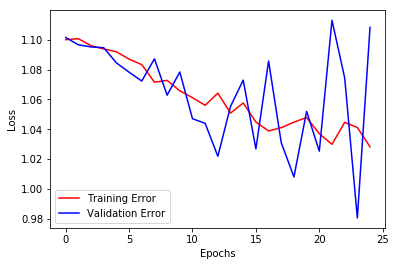

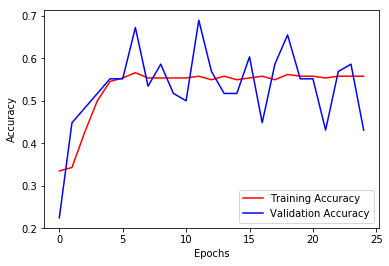

In [65]:
ecgModel = ecg2class()
ecgModel.train()